In [1]:
from pathlib import Path
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import re
from gelgenie.segmentation.helper_functions.general_functions import create_dir_if_empty

#### Main data prep functions

In [2]:
def modify_keys_and_add_prefix(data_dict, prefix):
    """
    Modify keys in a dictionary by removing a prefix and adding a new prefix.

    Parameters:
    - data_dict (dict): The input dictionary to be modified.
    - prefix (str): The prefix to be added to the modified keys.

    Modifies the keys in the input dictionary by removing a prefix (if present) and adding a new prefix.
    The modified dictionary is updated in-place.

    Example:
    >>> data_dict = {'old\\key_1': 10, 'old\\key_2': 20}
    >>> modify_keys_and_add_prefix(data_dict, 'new_')
    >>> print(data_dict)
    {'new_key1': 10, 'new_key2': 20}
    """
    # Iterate over a copy of keys to avoid changing the dictionary size during iteration
    for old_key in list(data_dict.keys()):
        # Find the index of the backslash character
        index = old_key.find("\\")
        
        # If the backslash is present, create a new key starting from the character after the backslash
        if index != -1:
            new_key = old_key[index + 1:]
        else:
            # If no backslash is found, use the original key
            new_key = old_key
        
        # Remove any underscores after the backslash (if present)
        new_key = new_key.split('_')[0] if '_' in new_key else new_key
        
        # Add the new prefix to the modified key
        new_key = f"{prefix}{new_key}"
        
        # Update the dictionary with the modified key
        data_dict[new_key] = data_dict.pop(old_key)


def min_max_normalize(df, group_column, target_column, new_column_name=None):
    """
    Min-Max normalize the values of a column in a Pandas DataFrame grouped by another column.

    Parameters:
    - df: Pandas DataFrame
    - group_column: Column used for grouping
    - target_column: Column to be min-max normalized
    - new_column_name: Name for the new column with normalized values (default is 'Normalized_<target_column>')

    Returns:
    - df_normalized: DataFrame with the new column containing min-max normalized values within each group
    """
    # If new_column_name is not provided, create a default name
    if new_column_name is None:
        new_column_name = f'Normalized_{target_column}'

    # Calculate the min and max values for each group
    min_values = df.groupby(group_column)[target_column].transform('min')
    max_values = df.groupby(group_column)[target_column].transform('max')

    # Apply the min-max normalization formula and add a new column
    df[new_column_name] = (df[target_column] - min_values) / (max_values - min_values)

    return df

def load_ga_csv_files_from_folders(parent_folder, prefix="ga_"):
    """
    Load CSV files from folders and create a dictionary of DataFrames with prefixed names.

    Parameters:
    - parent_folder (str): The path to the parent folder containing numbered subfolders.
    - prefix (str): The prefix to be added to the names of the DataFrames (default is "ga_").

    Returns:
    - dataframes (dict): A dictionary where keys are prefixed folder names, and values are corresponding DataFrames.
    """
    dataframes = {}  # Dictionary to store DataFrames

    # Iterate through folders in the parent folder
    for folder_name in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder_name)

        # Check if the item in the parent folder is a directory
        if os.path.isdir(folder_path):
            csv_file_path = os.path.join(folder_path, "collated_data_with_band_quality.csv")

            # Check if "collated_data_with_band_quality.csv" exists in the folder
            if os.path.isfile(csv_file_path):
                # Read the CSV file into a DataFrame
                dataframe = pd.read_csv(csv_file_path)

                # Add the prefix to the folder name and use it as the key in the dictionary
                prefixed_folder_name = f"{prefix}{folder_name}"
                dataframes[prefixed_folder_name] = dataframe

    return dataframes

def min_max_normalize_multiple_inplace(dataframes_dict, group_column, target_columns, new_column_prefix=None):
    """
    Min-Max normalize the values of specified columns in multiple DataFrames stored in a dictionary.
    Add normalized columns to the existing DataFrames.

    Parameters:
    - dataframes_dict (dict): A dictionary where keys are DataFrame names and values are DataFrames.
    - group_column (str): Column used for grouping in each DataFrame.
    - target_columns (list): List of columns to be min-max normalized in each DataFrame.
    - new_column_prefix (str): Prefix for the new columns with normalized values (default is 'Normalized_').

    Modifies the input DataFrames in-place by adding normalized columns.

    Example:
    >>> dataframes_dict = {'df1': pd.DataFrame({'Group': ['A', 'A', 'B', 'B'], 'Values1': [10, 15, 5, 8]}),
                           'df2': pd.DataFrame({'Group': ['C', 'C', 'D', 'D'], 'Values1': [50, 55, 45, 60]})}
    >>> min_max_normalize_multiple_inplace(dataframes_dict, group_column='Group', target_columns=['Values1'])
    >>> print(dataframes_dict['df1'])
       Group  Values1  Normalized_Values1
    0     A       10                0.00
    1     A       15                1.00
    2     B        5                0.00
    3     B        8                1.00
    """
    # If new_column_prefix is not provided, create a default name
    if new_column_prefix is None:
        new_column_prefix = 'Normalized_'

    # Iterate through DataFrames in the dictionary
    for df_name, df in dataframes_dict.items():
        # Iterate through target columns in each DataFrame
        for target_column in target_columns:
            # Calculate the min and max values for each group in the current DataFrame
            min_values = df.groupby(group_column)[target_column].transform('min')
            max_values = df.groupby(group_column)[target_column].transform('max')

            # Add a new column with the normalized values to the existing DataFrame
            new_column_name = f"{new_column_prefix}{target_column}"
            df[new_column_name] = (df[target_column] - min_values) / (max_values - min_values)

        # Update the dictionary with the modified DataFrame
        dataframes_dict[df_name] = df

        
def load_gg_csv_files_to_dict(folder_path, prefix="prefix_"):
    """
    Load CSV files from a folder and create a dictionary of DataFrames with prefixed keys.

    Parameters:
    - folder_path (str): The path to the folder containing CSV files.
    - prefix (str): The prefix to be added to the keys of the dictionary (default is "prefix_").

    Returns:
    - dataframes_dict (dict): A dictionary where keys are prefixed numbers, and values are corresponding DataFrames.
    """
    dataframes_dict = {}  # Dictionary to store DataFrames

    # Iterate through files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a CSV file
        if filename.endswith(".csv"):
            # Extract the number from the filename
            file_number = filename.split("_")[0]

            # Read the CSV file into a DataFrame
            file_path = os.path.join(folder_path, filename)
            dataframe = pd.read_csv(file_path)

            # Add the prefix to the number and use it as the key in the dictionary
            key = f"{prefix}{file_number}"
            dataframes_dict[key] = dataframe

    return dataframes_dict


def remove_spaces_from_column_headings_inplace(dataframes_dict):
    """
    Remove spaces at the start and end of column headings in pandas DataFrames stored in a dictionary.
    Replace the old columns with the modified column headings in-place.

    Parameters:
    - dataframes_dict (dict): A dictionary where keys are DataFrame names and values are DataFrames.

    Modifies the input DataFrames in-place by replacing old columns with modified column headings.
    """
    # Iterate through DataFrames in the dictionary
    for df_name, df in dataframes_dict.items():
        # Remove spaces at the start and end of column headings and replace the old columns
        df.columns = df.columns.str.strip()

        # Update the dictionary with the modified DataFrame
        dataframes_dict[df_name] = df

#### Data Preprocessing

In [5]:
# modify the below paths to point to wherever the gelgenie (gg)/gelanalyzer (ga)/ reference data is stored
gg_path = Path("/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_results/qupath_data/james_data_v3_fixed_global/Data_with_rolling_ball")
ga_path = Path("/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_results/gelanalyzer")
reference_path = Path("/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_results/reference_ladder_masses.csv")

gg_dfs = load_gg_csv_files_to_dict(gg_path, "gg_") # loads data and converts to dictionary
remove_spaces_from_column_headings_inplace(gg_dfs) # deletes spaces from column headings (due to an old bug that has now been fixed)

gg_dfs = {key: gg_dfs[key] for key in sorted(gg_dfs.keys(), key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)])}  # sorts by gel ID

ga_dfs = load_ga_csv_files_from_folders(ga_path)
ga_dfs = {key: ga_dfs[key] for key in sorted(ga_dfs.keys(), key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)])} # sorts by gel ID

for key, df in ga_dfs.items():
    ga_dfs[key] = df[df['Reliable Band'] != 0].copy() # removes all band data that has been deemed as unreliable

reference_df = pd.read_csv(reference_path)
reference_df.rename(columns={"NEB ladder": "NEB", " ThermoFisher ladder": "Thermo"}, inplace=True)
reference_df["Band ID"] = range(1, len(reference_df) + 1)
reference_df = pd.melt(reference_df, id_vars=["Band ID"], value_vars=["NEB", "Thermo"], var_name="Ladder", value_name="Intensity")
reference_df['Normalized_Intensity'] = reference_df.groupby("Ladder")["Intensity"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [6]:
print('Example gelgenie data:')
gg_dfs['gg_0']

Example gelgenie data:


,Lane ID,Band ID,Pixel Count,Average Intensity,Raw Volume,Local Corrected Volume,Global Corrected Volume,Rolling Ball Corrected Volume
0,1,1,376.0,26.015957,9782.0,4856.063857,5297.103333,5709.0
1,1,2,409.0,30.677262,12547.0,7064.778191,7668.482083,7974.0
2,1,3,367.0,31.940054,11722.0,6146.662321,7344.454583,7341.0
3,1,4,351.0,33.413105,11728.0,5660.595745,7541.301250,7412.0
4,1,5,395.0,30.524051,12057.0,6270.890274,7345.472917,7412.0
...,...,...,...,...,...,...,...,...
211,12,14,492.0,43.217480,21263.0,11534.032432,15394.465000,15079.0
212,12,15,501.0,40.638723,20360.0,10766.295486,14384.113750,14435.0
213,12,16,515.0,38.761165,19962.0,9940.058187,13819.122917,14026.0
214,12,17,582.0,31.378007,18262.0,8060.949640,11319.952500,11548.0


In [7]:
print('Example gelanalyzer data:')
ga_dfs['ga_31']

Example gelanalyzer data:


,Lane ID,Band ID,Raw Volume,Background Corrected Volume,Reliable Band
0,1,1,1891,916,1
1,1,2,1847,827,1
2,1,3,2019,1073,1
3,1,4,1900,881,1
4,1,5,2046,735,1
...,...,...,...,...,...
223,12,15,3145,1329,1
224,12,16,1802,447,1
225,12,17,1751,342,1
226,12,18,1394,242,1


#### Normalization

In [8]:
ga_columns = ['Raw Volume', 'Background Corrected Volume']
gg_columns = ['Raw Volume','Local Corrected Volume', 'Global Corrected Volume', 'Rolling Ball Corrected Volume']

min_max_normalize_multiple_inplace(ga_dfs, 'Lane ID', ga_columns)  
min_max_normalize_multiple_inplace(gg_dfs, 'Lane ID', gg_columns)

normalized_gg_columns = ['Normalized_Raw Volume', 'Normalized_Local Corrected Volume', 'Normalized_Global Corrected Volume', 'Normalized_Rolling Ball Corrected Volume']
normalized_ga_columns = ['Normalized_Raw Volume', 'Normalized_Background Corrected Volume']

#### Concatenation and final DF generation

In [9]:
for key, df in gg_dfs.items():
    df['App'] = "GG"
    df['Gel ID'] = key
    
for key, df in ga_dfs.items():
    df['App'] = "GA"
    df['Gel ID'] = key
    
concatenated_df = pd.concat([df for df in gg_dfs.values()] + [df for df in ga_dfs.values()], ignore_index=True)
concatenated_df['Gel ID'] = concatenated_df['Gel ID'].str.extract(r'_(\d+)')
concatenated_df['Gel ID'] = concatenated_df['Gel ID'].astype(int)
concatenated_df['Ladder'] = "Temp"
concatenated_df.loc[concatenated_df["Gel ID"].isin([0,1,2,3,4,5,6,7,8,9,10,11,12,32,34]), "Ladder"] = "Thermo"
concatenated_df.loc[concatenated_df["Gel ID"].isin([13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,33]), "Ladder"] = "NEB"

In [10]:
concatenated_df[concatenated_df['Gel ID'] == 32]

,Lane ID,Band ID,Pixel Count,Average Intensity,Raw Volume,Local Corrected Volume,Global Corrected Volume,Rolling Ball Corrected Volume,Normalized_Raw Volume,Normalized_Local Corrected Volume,Normalized_Global Corrected Volume,Normalized_Rolling Ball Corrected Volume,App,Gel ID,Background Corrected Volume,Reliable Band,Normalized_Background Corrected Volume,Ladder
5009,1,1,297.0,107.117845,31814.0,9542.270270,16615.449286,15335.0,0.000000,0.083733,0.000000,0.000000,GG,32,NaN,NaN,NaN,Thermo
5010,1,2,322.0,110.329193,35526.0,7815.346629,19048.110000,16956.0,0.070234,0.015447,0.080351,0.059141,GG,32,NaN,NaN,NaN,Thermo
5011,1,3,312.0,113.445513,35395.0,7424.710983,19428.845714,16887.0,0.067755,0.000000,0.092927,0.056624,GG,32,NaN,NaN,NaN,Thermo
5012,1,4,318.0,117.003145,37207.0,8618.736527,20933.804286,18116.0,0.102040,0.047214,0.142636,0.101463,GG,32,NaN,NaN,NaN,Thermo
5013,1,5,346.0,113.875723,39401.0,10436.250996,21694.944286,18503.0,0.143552,0.119083,0.167776,0.115582,GG,32,NaN,NaN,NaN,Thermo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220,12,14,812.0,137.464286,111621.0,28657.534351,70068.060000,49163.0,0.794712,0.635444,0.778690,0.662680,GG,32,NaN,NaN,NaN,Thermo
5221,12,15,769.0,139.535761,107303.0,24672.983920,67950.523571,46093.0,0.747398,0.513160,0.744016,0.590975,GG,32,NaN,NaN,NaN,Thermo
5222,12,16,820.0,135.695122,111270.0,27843.686441,69307.671429,47676.0,0.790866,0.610468,0.766239,0.627949,GG,32,NaN,NaN,NaN,Thermo
5223,12,17,768.0,137.653646,105718.0,24784.352941,66416.697143,48444.0,0.730030,0.516578,0.718900,0.645887,GG,32,NaN,NaN,NaN,Thermo


<AxesSubplot:xlabel='Lane ID', ylabel='Normalized_Raw Volume'>

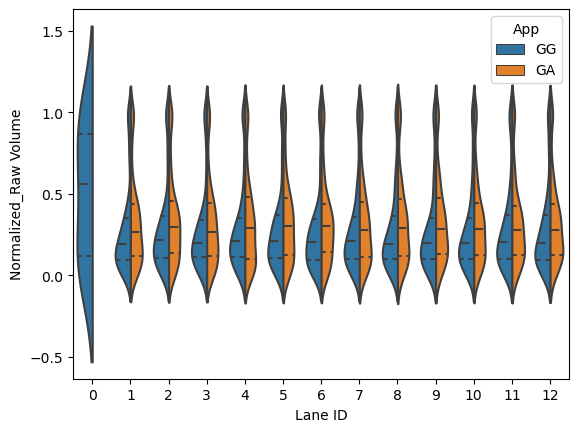

In [11]:
sns.violinplot(data=concatenated_df, x='Lane ID', y='Normalized_Raw Volume', hue='App', split=True, inner='quart')

In [12]:
melted_df = pd.melt(concatenated_df, id_vars=['Lane ID', 'Band ID', 'Gel ID', 'App'],
                    value_vars=['Pixel Count', 'Average Intensity', 'Raw Volume', 'Local Corrected Volume',
                                'Global Corrected Volume', 'Normalized_Raw Volume',
                                'Normalized_Local Corrected Volume', 'Normalized_Global Corrected Volume',
                                'Background Corrected Volume', 'Normalized_Background Corrected Volume'],
                    var_name='Variable', value_name='Volume')

In [13]:
melted_df # this df contains all the data split into rows for every single variable e.g. there is a single row for a normalised background value of a single band ID and lane ID.  The descriptor is held in the Variable column and the value is held in the Volumn column

,Lane ID,Band ID,Gel ID,App,Variable,Volume
0,1,1,0,GG,Pixel Count,376.000000
1,1,2,0,GG,Pixel Count,409.000000
2,1,3,0,GG,Pixel Count,367.000000
3,1,4,0,GG,Pixel Count,351.000000
4,1,5,0,GG,Pixel Count,395.000000
...,...,...,...,...,...,...
101555,12,15,31,GA,Normalized_Background Corrected Volume,0.933440
101556,12,16,31,GA,Normalized_Background Corrected Volume,0.226143
101557,12,17,31,GA,Normalized_Background Corrected Volume,0.141941
101558,12,18,31,GA,Normalized_Background Corrected Volume,0.061748


### Analysis of error vs reference ladder values

#### Merging in reference values into main dataframe

In [14]:
merged_df = pd.merge(concatenated_df, reference_df, on=['Band ID', 'Ladder'], how='left')
merged_df['Expected Value'] = merged_df['Normalized_Intensity']
merged_df

,Lane ID,Band ID,Pixel Count,Average Intensity,Raw Volume,Local Corrected Volume,Global Corrected Volume,Rolling Ball Corrected Volume,Normalized_Raw Volume,Normalized_Local Corrected Volume,...,Normalized_Rolling Ball Corrected Volume,App,Gel ID,Background Corrected Volume,Reliable Band,Normalized_Background Corrected Volume,Ladder,Intensity,Normalized_Intensity,Expected Value
0,1,1,376.0,26.015957,9782.0,4856.063857,5297.103333,5709.0,0.000000,0.050952,...,0.000000,GG,0,NaN,NaN,NaN,Thermo,20.0,0.000000,0.000000
1,1,2,409.0,30.677262,12547.0,7064.778191,7668.482083,7974.0,0.124927,0.170629,...,0.112889,GG,0,NaN,NaN,NaN,Thermo,20.0,0.000000,0.000000
2,1,3,367.0,31.940054,11722.0,6146.662321,7344.454583,7341.0,0.087652,0.120882,...,0.081340,GG,0,NaN,NaN,NaN,Thermo,20.0,0.000000,0.000000
3,1,4,351.0,33.413105,11728.0,5660.595745,7541.301250,7412.0,0.087923,0.094545,...,0.084878,GG,0,NaN,NaN,NaN,Thermo,20.0,0.000000,0.000000
4,1,5,395.0,30.524051,12057.0,6270.890274,7345.472917,7412.0,0.102788,0.127613,...,0.084878,GG,0,NaN,NaN,NaN,Thermo,20.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10151,12,15,NaN,NaN,3145.0,NaN,NaN,NaN,1.000000,NaN,...,NaN,GA,31,1329.0,1.0,0.933440,NEB,124.0,1.000000,1.000000
10152,12,16,NaN,NaN,1802.0,NaN,NaN,NaN,0.307375,NaN,...,NaN,GA,31,447.0,1.0,0.226143,NEB,49.0,0.257426,0.257426
10153,12,17,NaN,NaN,1751.0,NaN,NaN,NaN,0.281073,NaN,...,NaN,GA,31,342.0,1.0,0.141941,NEB,37.0,0.138614,0.138614
10154,12,18,NaN,NaN,1394.0,NaN,NaN,NaN,0.096957,NaN,...,NaN,GA,31,242.0,1.0,0.061748,NEB,32.0,0.089109,0.089109


In [15]:
# simple error used here
merged_df["Raw Difference"] = merged_df["Normalized_Raw Volume"] - merged_df['Expected Value']
merged_df["Local Difference"] = merged_df["Normalized_Local Corrected Volume"] - merged_df['Expected Value']
merged_df["Global Difference"] = merged_df["Normalized_Global Corrected Volume"] - merged_df['Expected Value']
merged_df["Background Difference"] = merged_df["Normalized_Background Corrected Volume"] - merged_df['Expected Value']
merged_df["Rolling Ball Difference"] = merged_df["Normalized_Rolling Ball Corrected Volume"] - merged_df['Expected Value']
merged_df

,Lane ID,Band ID,Pixel Count,Average Intensity,Raw Volume,Local Corrected Volume,Global Corrected Volume,Rolling Ball Corrected Volume,Normalized_Raw Volume,Normalized_Local Corrected Volume,...,Normalized_Background Corrected Volume,Ladder,Intensity,Normalized_Intensity,Expected Value,Raw Difference,Local Difference,Global Difference,Background Difference,Rolling Ball Difference
0,1,1,376.0,26.015957,9782.0,4856.063857,5297.103333,5709.0,0.000000,0.050952,...,NaN,Thermo,20.0,0.000000,0.000000,0.000000,0.050952,0.000000,NaN,0.000000
1,1,2,409.0,30.677262,12547.0,7064.778191,7668.482083,7974.0,0.124927,0.170629,...,NaN,Thermo,20.0,0.000000,0.000000,0.124927,0.170629,0.116156,NaN,0.112889
2,1,3,367.0,31.940054,11722.0,6146.662321,7344.454583,7341.0,0.087652,0.120882,...,NaN,Thermo,20.0,0.000000,0.000000,0.087652,0.120882,0.100285,NaN,0.081340
3,1,4,351.0,33.413105,11728.0,5660.595745,7541.301250,7412.0,0.087923,0.094545,...,NaN,Thermo,20.0,0.000000,0.000000,0.087923,0.094545,0.109927,NaN,0.084878
4,1,5,395.0,30.524051,12057.0,6270.890274,7345.472917,7412.0,0.102788,0.127613,...,NaN,Thermo,20.0,0.000000,0.000000,0.102788,0.127613,0.100335,NaN,0.084878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10151,12,15,NaN,NaN,3145.0,NaN,NaN,NaN,1.000000,NaN,...,0.933440,NEB,124.0,1.000000,1.000000,0.000000,NaN,NaN,-0.066560,NaN
10152,12,16,NaN,NaN,1802.0,NaN,NaN,NaN,0.307375,NaN,...,0.226143,NEB,49.0,0.257426,0.257426,0.049949,NaN,NaN,-0.031283,NaN
10153,12,17,NaN,NaN,1751.0,NaN,NaN,NaN,0.281073,NaN,...,0.141941,NEB,37.0,0.138614,0.138614,0.142459,NaN,NaN,0.003327,NaN
10154,12,18,NaN,NaN,1394.0,NaN,NaN,NaN,0.096957,NaN,...,0.061748,NEB,32.0,0.089109,0.089109,0.007848,NaN,NaN,-0.027361,NaN


In [16]:
output_dir = '/Users/matt/Desktop/pdf_error_plots'
create_dir_if_empty(output_dir)

In [17]:
merged_df.to_csv(join(output_dir,'merged_df.csv'),index=False)